# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
from datetime import datetime
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

In [63]:
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder


In [77]:
from tensorflow.keras import callbacks, layers, models, optimizers, regularizers
import tensorflow.keras.backend as K

In [162]:
values2017_dict = dict()
values2017_dict['PRAEGENDE_JUGENDJAHRE'] = {-1: 'unknown', 0:'unknown',
1: '40ies - war years (Mainstream, O+W)',
2:'40ies - reconstruction years (Avantgarde, O+W)',
3:'50ies - economic miracle (Mainstream, O+W)',
4:'50ies - milk bar / Individualisation (Avantgarde, O+W)',
5:'60ies - economic miracle (Mainstream, O+W)',
6:'60ies - generation 68 / student protestors (Avantgarde, W)',
7:'60ies - opponents to the building of the Wall (Avantgarde, O)',
8:'70ies - family orientation (Mainstream, O+W)',
9:'70ies - peace movement (Avantgarde, O+W)',
10:'80ies - Generation Golf (Mainstream, W)',
11:'80ies - ecological awareness (Avantgarde, W)',
12:'80ies - FDJ / communist party youth organisation (Mainstream, O)',
13:'80ies - Swords into ploughshares (Avantgarde, O)',
14:'90ies - digital media kids (Mainstream, O+W)',
15:'90ies - ecological awareness (Avantgarde, O+W)'
}

values2017_dict['D19_KONSUMTYP'] = {
-1: 'unknown',
1: 'Universal',
2: 'Versatile',
3: 'Gourmet',
4: 'Family',
5: 'Informed',
6: 'Modern',
9: 'Inactive'
}

values2017_dict['CAMEO_DEU_2015'] = {'-1':'unknown', -1:'unknown',
'1A': 'Work-Life-Balance',
'1B': 'Wealthy Best Ager',
'1C': 'Successful Songwriter',
'1D': 'Old Nobility',
'1E': 'City Nobility',
'2A': 'Cottage Chic',
'2B': 'Noble Jogger',
'2C': 'Established gourmet',
'2D': 'Fine Management',
'3A': 'Career & Family',
'3B': 'Powershopping Families',
'3C': 'Rural Neighborhood',
'3D': 'Secure Retirement',
'4A': 'Family Starter',
'4B': 'Family Life',
'4C': 'String Trimmer',
'4D': 'Empty Nest',
'4E': 'Golden Ager',
'5A': 'Younger Employees',
'5B': 'Suddenly Family',
'5C': 'Family First',
'5D': 'Stock Market Junkies',
'5E': 'Coffee Rider',
'5F': 'Active Retirement',
'6A': 'Jobstarter',
'6B': 'Petty Bourgeois',
'6C': 'Long-established',
'6D': 'Sportgardener',
'6E': 'Urban Parents',
'6F': 'Frugal Aging',
'7A': 'Journeymen',
'7B': 'Mantaplatte',
'7C': 'Factory Worker',
'7D': 'Rear Window',
'7E': 'Interested Retirees',
'8A': 'Multi-culteral',
'8B': 'Young & Mobile',
'8C': 'Prefab',
'8D': 'Town Seniors',
'9A': 'First Shared Apartment',
'9B': 'Temporary Workers',
'9C': 'Afternoon Talk Show',
'9D': 'Mini-Jobber',
'9E': 'Socking Away'
}



# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Read Data and drop useless features

In [5]:
# load in the data
azdias = pd.read_csv('./arvato_data/Udacity_AZDIAS_052018.csv', sep=';', 
                     low_memory=False, index_col='LNR')
customers = pd.read_csv('./arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', 
                        low_memory=False, index_col='LNR')

In [6]:
customers['EINGEFUEGT_AM'].head()
# LNR
# 9626      1992-02-12 00:00:00
# 9628                      NaN
# 143872    1992-02-10 00:00:00
# 143873    1992-02-10 00:00:00
# 143874    1992-02-12 00:00:00

LNR
9626      1992-02-12 00:00:00
9628                      NaN
143872    1992-02-10 00:00:00
143873    1992-02-10 00:00:00
143874    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object

The column 'EINGEFUEGT_AM' represents a date. Translated from german, it means 'INSEARTED_AT' It's meaning is unclear and not described in the acompanying Excle files. I drop it from all dataset

In [7]:
azdias.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
customers.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [8]:
print(azdias.shape)
azdias.head()

(891221, 364)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [9]:
print(customers.shape)
customers.head()

(191652, 367)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [10]:
mailout = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', 
                      sep=';', index_col='LNR')
test = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TEST.csv', 
                      sep=';', index_col='LNR')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
mailout.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
test.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [12]:
print(mailout.shape)
mailout.head()

(42962, 365)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [13]:
mailout['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [14]:
#532/42430  # 0.012538

In [15]:
print(test.shape)
test.head()

(42833, 364)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [16]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Exploratory analysis

### Dealing with unknown values

Columns with the broad information about the customers have no missing values.

In [17]:
customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].isnull().sum()

CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
PRODUCT_GROUP      0
dtype: int64

Other columns are common for the 4 datasets: azdias, customers, mailout_train and testm data. Here is the percentage of missing values in each column

In [18]:
# ----- check missing values
azdias_nulls = azdias.isnull().sum()
customers_nulls = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1).isnull().sum()
mailout_nulls = mailout.drop("RESPONSE", axis=1).isnull().sum()
test_nulls = test.isnull().sum()
#
acmt_nulls = pd.concat([azdias_nulls/len(azdias), customers_nulls/len(customers),
                        mailout_nulls/len(mailout), test_nulls/len(test)], axis=1)
acmt_nulls.columns = ['azdias', 'customers', 'mailout', 'test']
#
display(HTML('<H3> Prozent of missing values in each dataset </H3> '))
acmt_nulls

,azdias,customers,mailout,test
AGER_TYP,0.000000,0.000000,0.000000,0.000000
AKT_DAT_KL,0.082470,0.243128,0.162213,0.160834
ALTER_HH,0.082470,0.243128,0.162213,0.160834
ALTER_KIND1,0.909048,0.938607,0.953727,0.953004
ALTER_KIND2,0.966900,0.973389,0.982403,0.982210
ALTER_KIND3,0.993077,0.993347,0.995950,0.995307
ALTER_KIND4,0.998648,0.998769,0.999046,0.999089
ALTERSKATEGORIE_FEIN,0.295041,0.270501,0.189819,0.189527
ANZ_HAUSHALTE_AKTIV,0.104517,0.260509,0.181020,0.178064
ANZ_HH_TITEL,0.108848,0.271899,0.191937,0.190180


Percentage of missing values


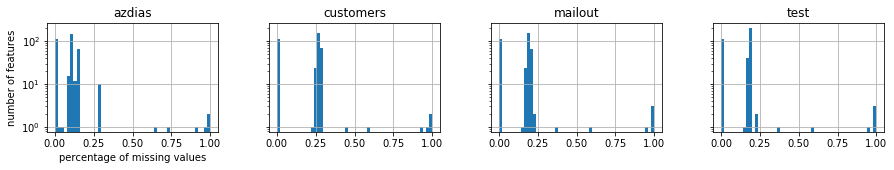

In [38]:
print('Percentage of missing values')
ax = acmt_nulls.hist(bins=50, layout=(1,4), figsize=(15,2), log=True, sharey=True);
ax[0][0].set_ylabel('number of features');
ax[0][0].set_xlabel('percentage of missing values');

The histograms above shows that nearly each column has explicitely unknown values (empty strings in CSV file).
Around 100 columns in each dataset have few missing values and over 200 columns have around 25-25% missing values.

At the same time, from data documentation we know, that 

    -1 always encodes unknown values
    0 sometime encodes unknown values and sometimes is meaningful
    9 sometime encodes unknown values and sometimes is meaningful
    
Therefore I replace missing values with -1.

In [21]:
object_columns = azdias.select_dtypes(include='object').columns.tolist()
object_columns

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'OST_WEST_KZ']

In [22]:
azdias[object_columns] = azdias[object_columns].fillna('-1', downcast='infer')
azdias = azdias.fillna(-1, downcast='infer')
display(azdias.head())
azdias.to_pickle('arvato_data/azdias_cleaned.pkl')

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [23]:
customers[object_columns] = customers[object_columns].fillna('-1', downcast='infer')
customers = customers.fillna(-1, downcast='infer')
display(customers.head())
customers.to_pickle('arvato_data/customers_cleaned.pkl')

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [25]:
mailout[object_columns] = mailout[object_columns].fillna('-1', downcast='infer')
mailout = mailout.fillna(-1, downcast='infer')
display(mailout.head())
mailout.to_pickle('arvato_data/mailout_cleaned.pkl')

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [26]:
test[object_columns] = test[object_columns].fillna('-1', downcast='infer')
test = test.fillna(-1, downcast='infer')
display(test.head())
test.to_pickle('arvato_data/test_cleaned.pkl')

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

### Feature Selection before Customer Segmentation

In Part 1 - Customer Segmentation Report - the unsupervised algorithms should be built on a small number of relevant features. In the absence of domain-specific knowledge, I rely on Machine Learning algorithms to perform feature selection. 

Strictly speaking, before applying any ML algorithm, one should think about 

* a way of dealing with categorical features
* feature normalization

With all 364 features being categorical or ordinal this is a problem on itself.

##### Preparing data for supervised learning

Manual exploratory analysis for 364 columns is infeasible for the time of the capstone project. So use ML methods to determine which columns are most relevant for distinguishing customers from general population. 

I combine the azdias and customers datasets and define the binary variable 'is_customer'. Then I consider predicting 'is_customer' as binary classification (supervised learning). Many classification algorithms also return the feature importance. 

In [48]:
if 'azdias' not in dir():
    azdias = pd.read_pickle('arvato_data/azdias_cleaned.pkl')
print('adzias', azdias.shape)

adzias (891221, 364)


In [49]:
if 'customers' not in dir():
    customers = pd.read_pickle('arvato_data/customers_cleaned.pkl')
print('customers',customers.shape)

customers (191652, 367)


##### Reformulate problem as binary classification customer/not.  

Concatenate  customer and azdias dataset (= data) and set a response variable (is_customer)

In [50]:
is_customer = pd.concat([pd.Series(1, index=customers.index),
                         pd.Series(0, index=azdias.index)], axis=0, verify_integrity=True, copy=True)
data = pd.concat([customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1),
                  azdias], axis=0, verify_integrity=True, copy=True)


In [51]:
#data.head()

Shuffle data before classification

In [52]:
# shuffle data
is_customer = is_customer.sample(frac=1.0)
data = data.loc[is_customer.index]

##### Important features from Random forest

As I already mentioned, before applying any ML algorithm, one should think about a way of dealing with categorical features and feature normalization.

Fortunately tree-based models like RandomForest or GradientBoosting Regressor are insensitive to feature scaling and can work with the data as they are.  The python implementations (here, scikit-learn) also provides automatical calculation of feature importance.  I keep the categorical features in numerical form as they are. This is not ideal, but enough to estimate importance of each feature. Those are the features that distinguish customers from general population.

I encode bbject (string) columns in numeric form.

In [53]:
#object_columns = data.select_dtypes(include='object').columns.tolist()
#print(object_columns)
#data[object_columns].head()

In [55]:
from sklearn.preprocessing import LabelEncoder
les = dict()
for colu in object_columns:
    tmp = pd.concat([data[colu].astype(str), 
                     mailout[colu].astype(str), 
                     test[colu].astype(str)], axis=0)
    les[colu] = LabelEncoder().fit(tmp)
    data[colu] = les[colu].transform(data[colu].astype(str))

In [56]:
data = data.astype(int)

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1200, min_samples_leaf=64)

In [58]:
%%time
rf.fit(data, is_customer)

CPU times: user 1h 49min 31s, sys: 0 ns, total: 1h 49min 31s
Wall time: 1h 49min 35s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=64, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##### Important features

D19_SOZIALES             0.184252
D19_KONSUMTYP_MAX        0.054699
D19_KONSUMTYP            0.049342
VK_ZG11                  0.037792
ALTERSKATEGORIE_GROB     0.029314
VK_DISTANZ               0.025507
CJT_TYP_6                0.024207
CJT_TYP_3                0.021592
CJT_TYP_5                0.021314
PRAEGENDE_JUGENDJAHRE    0.020655
EXTSEL992                0.020320
AKT_DAT_KL               0.017178
CJT_TYP_4                0.016902
KOMBIALTER               0.016540
EINGEZOGENAM_HH_JAHR     0.016453
RT_SCHNAEPPCHEN          0.015864
CJT_TYP_1                0.013061
VK_DHT4A                 0.011707
FINANZ_VORSORGER         0.011497
FINANZ_ANLEGER           0.010581
FINANZ_SPARER            0.010118
RT_UEBERGROESSE          0.009451
AGER_TYP                 0.009400
RT_KEIN_ANREIZ           0.009128
LP_STATUS_FEIN           0.008816
dtype: float64

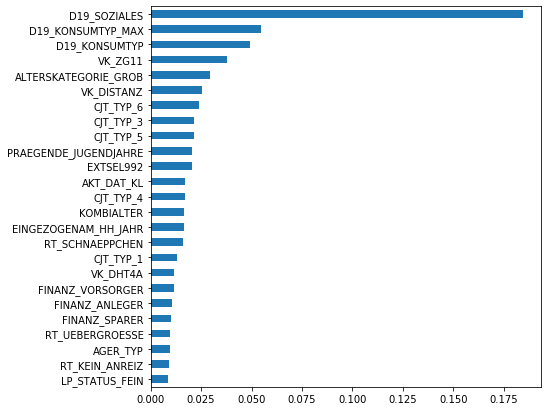

In [59]:
feature_importances = pd.Series(rf.feature_importances_, index=data.columns).sort_values(ascending=False)
display(feature_importances.head(25))

feature_importances.head(25)[::-1].plot.barh(figsize=(7,7));

##### Useless features

In [60]:
feature_importances.tail(25)

KBA05_KRSKLEIN              6.832079e-05
D19_ENERGIE                 6.466338e-05
KBA13_KW_30                 6.075020e-05
D19_LEBENSMITTEL            5.844447e-05
D19_NAHRUNGSERGAENZUNG      5.492284e-05
KBA05_ANTG4                 5.026033e-05
KBA13_KRSSEG_VAN            4.964147e-05
KBA13_KRSSEG_OBER           4.680783e-05
D19_TELKO_ANZ_24            4.449374e-05
D19_TELKO_OFFLINE_DATUM     3.821470e-05
D19_BANKEN_ANZ_12           3.624020e-05
KBA13_KMH_110               3.174227e-05
D19_BANKEN_REST             3.083185e-05
KBA05_SEG6                  2.846212e-05
D19_BANKEN_OFFLINE_DATUM    2.227120e-05
D19_TIERARTIKEL             1.797937e-05
D19_GARTEN                  1.649690e-05
D19_DIGIT_SERV              1.267299e-05
D19_VERSI_OFFLINE_DATUM     1.145583e-05
ALTER_KIND3                 8.437106e-06
D19_TELKO_ANZ_12            8.288292e-06
D19_BANKEN_LOKAL            1.446717e-06
D19_TELKO_ONLINE_DATUM      3.048199e-07
D19_VERSI_ONLINE_DATUM      5.891503e-08
ALTER_KIND4     

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

##### Read cleaned data

In [6]:
if 'adzias' not in dir():
    azdias = pd.read_pickle('arvato_data/azdias_cleaned.pkl')
print('adzias', azdias.shape)

adzias (891221, 364)


In [7]:
if 'customers' not in dir():
    customers = pd.read_pickle('arvato_data/customers_cleaned.pkl')
print('customers',customers.shape)

customers (191652, 367)


## Compare distributions for the top-10 features

In [43]:
is_customer = pd.concat([pd.Series(1, index=customers.index),
                         pd.Series(0, index=azdias.index)], axis=0, verify_integrity=True, copy=True)
data = pd.concat([customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1),
                  azdias], axis=0, verify_integrity=True, copy=True)

In [44]:
top10_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'ALTERSKATEGORIE_GROB', 'D19_KONSUMTYP',
                 'VK_ZG11', 'VK_DISTANZ', 'CJT_TYP_6', 'CJT_TYP_5',  'CJT_TYP_3', 'PRAEGENDE_JUGENDJAHRE']

In [45]:
import seaborn as sns

In [46]:
# ----- empty plots from seavborn
# fig, ax = plt.subplots(5,2, figsize=(15,20))
# for i, colu in enumerate(top10_columns):
#     n = azdias[colu].nunique()
#     # ----- tmp DataFrame:
#     # ----- percentage of people for each category, calculated separately for customers and not-customers
#     #tmp = gr[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer'})
#     tmp = data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(
#                         columns={'level_0':'is_customer', colu: 'n_people'}).reset_index()
    
#     for c in [0,1]:
#         tmp.loc[tmp.is_customer==c, 'percent_people'] = \
#                   tmp.loc[tmp.is_customer==c, 'n_people']/tmp.loc[tmp.is_customer==c, 'n_people'].sum(axis=0)
    
#     #display(tmp)
#     # ----- visualize
#     if n<20:
#         #tmp.plot.barh(ax=ax[i//2, i%2], title=colu, c='is_customer')
#         _ = sns.catplot(ax=ax[i//2, i%2], kind='bar', 
#                             x=colu, y='percent_people', hue='is_customer', data=tmp)
#     else:
#         #tmp.plot.hist(ax=ax[i//2, i%2], title=colu, c='is_customer', bins=100, log=True)
#         _ = sns.lineplot(ax=ax[i//2, i%2], lw=3, 
#                                x=colu, y='percent_people', hue='is_customer', data=tmp)
# display(fig)
# plt.close(fig)

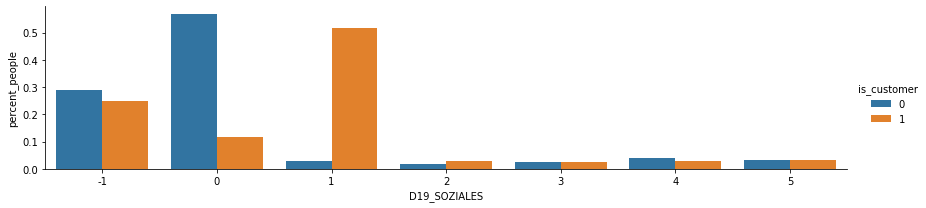

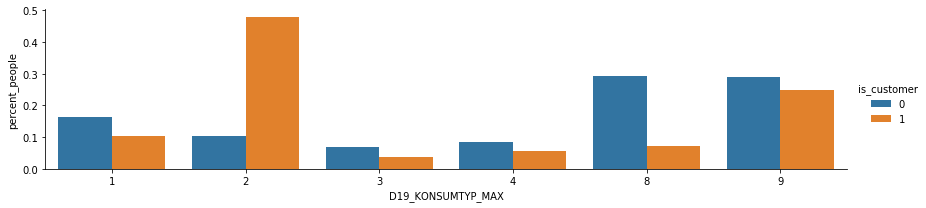

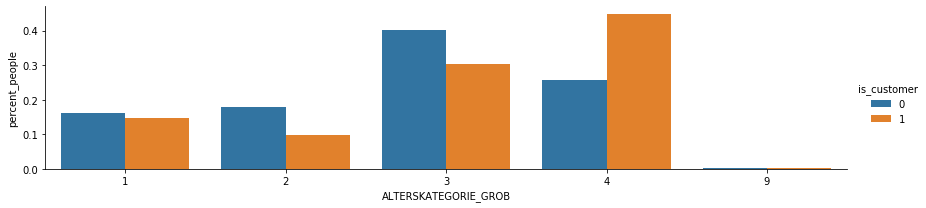

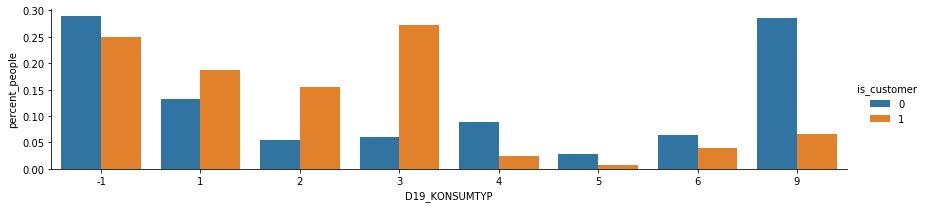

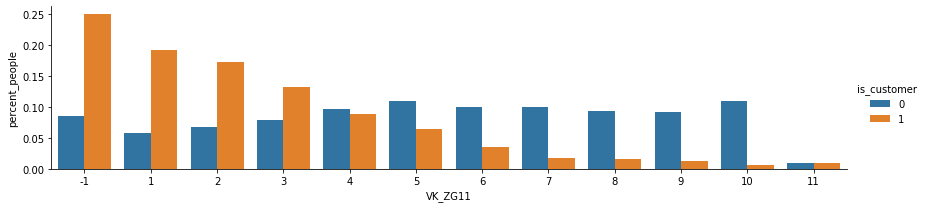

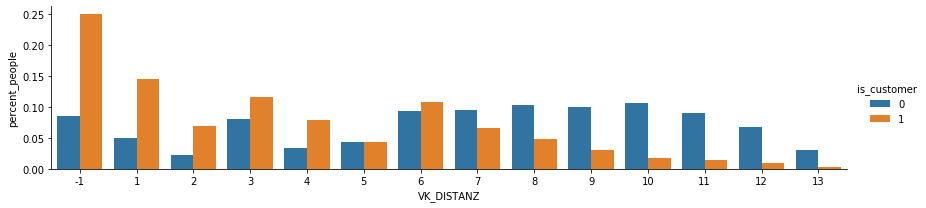

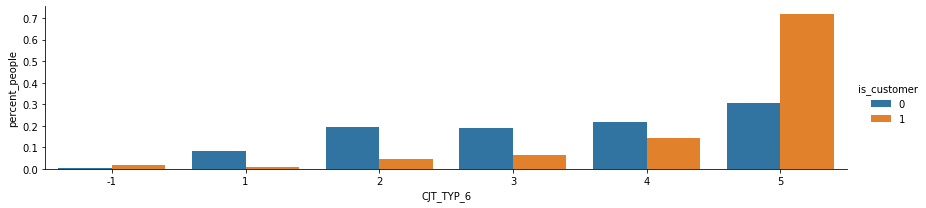

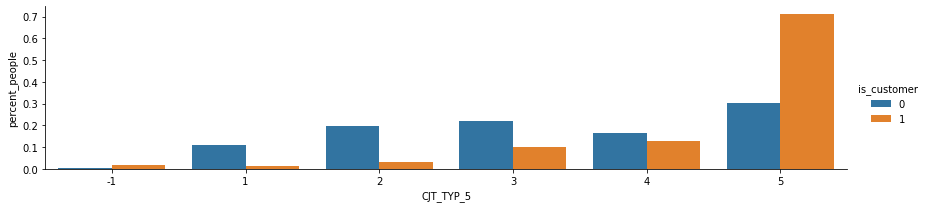

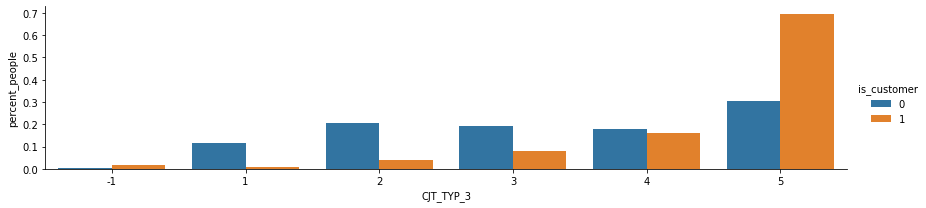

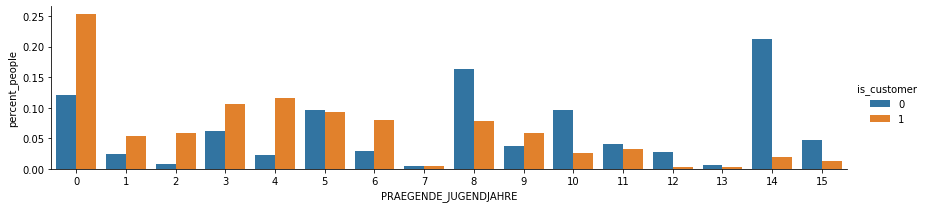

In [47]:
for i, colu in enumerate(top10_columns):
    n = azdias[colu].nunique()
    # ----- tmp DataFrame:
    # ----- percentage of people for each category, calculated separately for customers and not-customers
    #tmp = gr[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer'})
    tmp = data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(
                        columns={'level_0':'is_customer', colu: 'n_people'}).reset_index()
    
    for c in [0,1]:
        tmp.loc[tmp.is_customer==c, 'percent_people'] = \
                  tmp.loc[tmp.is_customer==c, 'n_people']/tmp.loc[tmp.is_customer==c, 'n_people'].sum(axis=0)
    
    #display(tmp)
    # ----- visualize
    ax = sns.catplot(kind='bar', x=colu, y='percent_people', hue='is_customer', data=tmp, 
                     height=3, aspect=4);
#display(fig)
#plt.close(fig)

We clearly see that 

1) customers significantly overrepresented in the group '1' and underrepresented in group '0' of 'D19_SOZIALES'. Unfortunately, 'D19_SOZIALES' is not documented in Excel files.

2) customers significantly overrepresented in the group '2' and underrepresented in group '8' of 'D19_KONSUMTYP_MAX'. Unfortunately, 'D19_KONSUMTYP_MAX' is not documented in Excel files.

3) customers overrepresented in the group '4'='>60 year' and underrepresented in groups '2'='30-45 years' and '3'=46-60 years' of 'ALTERKATETGORIE_GROB'.

4) customers overrepresented in the groups '3'='Gourmet' and '2'='Versatile' and significantly underrepresented in groups '9'='Inactive' and '4'=Family' of 'D19_Konsumtyp'='consumption type'.

5) customers significantly overrepresented in the groups with low values and underrepresented in groups with high values of 'VK_ZG11'. Unfortunately, 'VK_ZG11' is not documented in Excel files.

6) customers significantly overrepresented in the group '5' and underrepresented in groups '1', '2' and '3' of 'CJT_TYP_6'. Unfortunately, 'CJT_TYP_6' is not documented in Excel files.

7) customers significantly overrepresented in the group '5' and underrepresented in groups '1', '2' and '3' of 'CJT_TYP_5'. Unfortunately, 'CJT_TYP_5' is not documented in Excel files.

8) customers significantly overrepresented in the group '5' and underrepresented in groups '1', '2' and '3' of 'CJT_TYP_3'. Unfortunately, 'CJT_TYP_3' is not documented in Excel files.

9) customers are overrepresented in the following groups of 'PRAEGENDE_JUGENDJAHRE' = dominating movement in the person's youth (avantgarde or mainstream). This agrees with the previous finding abour the age of the customer.

    '0'='unknown', 
    '2'='40ies-reconstruction years (Avantgarde, O+W)', 
    '4'='50ies - milk bar / Individualisation (Avantgarde, O+W)', 
    '6'='60ies - generation 68 / student protestors (Avantgarde, W)' 

10) customers are underrepresented in the following groups of 'PRAEGENDE_JUGENDJAHRE' = dominating movement in the person's youth (avantgarde or mainstream). This agrees with the previous finding abour the age of the customer.

    '10'='80ies - Generation Golf (Mainstream, W)' 
    '12'='80ies - FDJ / communist party youth organisation (Mainstream, O)'
    '14'='90ies - digital media kids (Mainstream, O+W)'
    '15'='90ies - ecological awareness (Avantgarde, O+W)'



## Dimensionality Reduction

The most methods of dimensionality reduction (Principal Component Analysis, Factor Analysis) are meaningful for classical numerical features. For categorical features I propose to OHE-encode those and then use the Latent Dirichlet Allocation (LDA). 

Origonally developed to discover topics in text documents, LDA is intrinsically suited to work with high-dimensional sparse data. This exactly corresponds to our data after OHE. 

Simultaneously, the result of LDA can be interpreted as clustering. Each found 'topic' will correspond to cluster.

### OHE  top-N categorical  columns

All clustering algorithms are based on the concept of distance between points. For categorical data this concept is meaningful after applying One-Hot Encoding (OHE) to all categorical columns

In [8]:
top10_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'ALTERSKATEGORIE_GROB', 'D19_KONSUMTYP',
                 'VK_ZG11', 'VK_DISTANZ', 'CJT_TYP_6', 'CJT_TYP_5',  'CJT_TYP_3', 'PRAEGENDE_JUGENDJAHRE']

##### OHE for all categorical values

In [10]:
azdias_ohe = azdias[top10_columns].astype(int).copy()
#columns_for_OHE = [c for c in top10_columns if c not in ('EXTSEL992')]
azdias_ohe = pd.get_dummies(azdias_ohe, drop_first=True, columns=top10_columns).astype(int)
print('Azdias', azdias_ohe.shape) # (,75)
azdias_ohe.head()

Azdias (891221, 76)


,D19_SOZIALES_0,D19_SOZIALES_1,D19_SOZIALES_2,D19_SOZIALES_3,D19_SOZIALES_4,D19_SOZIALES_5,D19_KONSUMTYP_MAX_2,D19_KONSUMTYP_MAX_3,D19_KONSUMTYP_MAX_4,D19_KONSUMTYP_MAX_8,D19_KONSUMTYP_MAX_9,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,D19_KONSUMTYP_1,D19_KONSUMTYP_2,D19_KONSUMTYP_3,D19_KONSUMTYP_4,D19_KONSUMTYP_5,D19_KONSUMTYP_6,D19_KONSUMTYP_9,VK_ZG11_1,VK_ZG11_2,VK_ZG11_3,VK_ZG11_4,VK_ZG11_5,VK_ZG11_6,VK_ZG11_7,VK_ZG11_8,VK_ZG11_9,VK_ZG11_10,VK_ZG11_11,VK_DISTANZ_1,VK_DISTANZ_2,VK_DISTANZ_3,VK_DISTANZ_4,VK_DISTANZ_5,VK_DISTANZ_6,VK_DISTANZ_7,VK_DISTANZ_8,VK_DISTANZ_9,VK_DISTANZ_10,VK_DISTANZ_11,VK_DISTANZ_12,VK_DISTANZ_13,CJT_TYP_6_1,CJT_TYP_6_2,CJT_TYP_6_3,CJT_TYP_6_4,CJT_TYP_6_5,CJT_TYP_5_1,CJT_TYP_5_2,CJT_TYP_5_3,CJT_TYP_5_4,CJT_TYP_5_5,CJT_TYP_3_1,CJT_TYP_3_2,CJT_TYP_3_3,CJT_TYP_3_4,CJT_TYP_3_5,PRAEGENDE_JUGENDJAHRE_1,PRAEGENDE_JUGENDJAHRE_2,PRAEGENDE_JUGENDJAHRE_3,PRAEGENDE_JUGENDJAHRE_4,PRAEGENDE_JUGENDJAHRE_5,PRAEGENDE_JUGENDJAHRE_6,PRAEGENDE_JUGENDJAHRE_7,PRAEGENDE_JUGENDJAHRE_8,PRAEGENDE_JUGENDJAHRE_9,PRAEGENDE_JUGENDJAHRE_10,PRAEGENDE_JUGENDJAHRE_11,PRAEGENDE_JUGENDJAHRE_12,PRAEGENDE_JUGENDJAHRE_13,PRAEGENDE_JUGENDJAHRE_14,PRAEGENDE_JUGENDJAHRE_15
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
910220,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
910225,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
910226,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
910241,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [11]:
customers_ohe = customers[top10_columns].astype(int).copy()
#columns_for_OHE = [c for c in top10_columns if c not in ('EXTSEL992')]
customers_ohe = pd.get_dummies(customers_ohe, drop_first=True, columns=top10_columns).astype(int)
print('Customers', customers_ohe.shape) # (,75)
customers_ohe.head()

Customers (191652, 76)


,D19_SOZIALES_0,D19_SOZIALES_1,D19_SOZIALES_2,D19_SOZIALES_3,D19_SOZIALES_4,D19_SOZIALES_5,D19_KONSUMTYP_MAX_2,D19_KONSUMTYP_MAX_3,D19_KONSUMTYP_MAX_4,D19_KONSUMTYP_MAX_8,D19_KONSUMTYP_MAX_9,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,D19_KONSUMTYP_1,D19_KONSUMTYP_2,D19_KONSUMTYP_3,D19_KONSUMTYP_4,D19_KONSUMTYP_5,D19_KONSUMTYP_6,D19_KONSUMTYP_9,VK_ZG11_1,VK_ZG11_2,VK_ZG11_3,VK_ZG11_4,VK_ZG11_5,VK_ZG11_6,VK_ZG11_7,VK_ZG11_8,VK_ZG11_9,VK_ZG11_10,VK_ZG11_11,VK_DISTANZ_1,VK_DISTANZ_2,VK_DISTANZ_3,VK_DISTANZ_4,VK_DISTANZ_5,VK_DISTANZ_6,VK_DISTANZ_7,VK_DISTANZ_8,VK_DISTANZ_9,VK_DISTANZ_10,VK_DISTANZ_11,VK_DISTANZ_12,VK_DISTANZ_13,CJT_TYP_6_1,CJT_TYP_6_2,CJT_TYP_6_3,CJT_TYP_6_4,CJT_TYP_6_5,CJT_TYP_5_1,CJT_TYP_5_2,CJT_TYP_5_3,CJT_TYP_5_4,CJT_TYP_5_5,CJT_TYP_3_1,CJT_TYP_3_2,CJT_TYP_3_3,CJT_TYP_3_4,CJT_TYP_3_5,PRAEGENDE_JUGENDJAHRE_1,PRAEGENDE_JUGENDJAHRE_2,PRAEGENDE_JUGENDJAHRE_3,PRAEGENDE_JUGENDJAHRE_4,PRAEGENDE_JUGENDJAHRE_5,PRAEGENDE_JUGENDJAHRE_6,PRAEGENDE_JUGENDJAHRE_7,PRAEGENDE_JUGENDJAHRE_8,PRAEGENDE_JUGENDJAHRE_9,PRAEGENDE_JUGENDJAHRE_10,PRAEGENDE_JUGENDJAHRE_11,PRAEGENDE_JUGENDJAHRE_12,PRAEGENDE_JUGENDJAHRE_13,PRAEGENDE_JUGENDJAHRE_14,PRAEGENDE_JUGENDJAHRE_15
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9626,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9628,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
143872,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
143873,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
143874,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [12]:
assert all(azdias_ohe.columns==customers_ohe.columns)

### Latent Dirichlet Allocation (LDA)

In [18]:
azdias_csr = scipy.sparse.csr_matrix(azdias_ohe) 
customers_csr = scipy.sparse.csr_matrix(customers_ohe) 
assert azdias_csr.getformat()=='csr'

Since I start with 10 features, I also select 10 components for dimensionality reduction.

In [45]:
lda = LatentDirichletAllocation(n_components=10, learning_method='online', batch_size=2**12, 
                                random_state=3290, verbose=1, max_iter=10, mean_change_tol=0.01, n_jobs=-1)

In [46]:
%%time
lda.fit(azdias_csr)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 1min 10s, sys: 1.64 s, total: 1min 12s
Wall time: 12min 58s


LatentDirichletAllocation(batch_size=4096, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.01, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=3290,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

##### LDA components

can be viewed as number of times that specific feature (column) was used in specific dimension ('topic' in classical intepretation)

In [47]:
#Variational parameters for topic word distribution. 
# Since the complete conditional for topic word distribution is a Dirichlet, components_[i, j] 
# can be viewed as pseudocount that represents the number of times word j was assigned to topic i. 
# It can also be viewed as distribution over the words for each topic after normalization: 
#model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
lda_components = pd.DataFrame(lda.components_, columns=azdias_ohe.columns)
lda_components
                                

,D19_SOZIALES_0,D19_SOZIALES_1,D19_SOZIALES_2,D19_SOZIALES_3,D19_SOZIALES_4,D19_SOZIALES_5,D19_KONSUMTYP_MAX_2,D19_KONSUMTYP_MAX_3,D19_KONSUMTYP_MAX_4,D19_KONSUMTYP_MAX_8,D19_KONSUMTYP_MAX_9,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,D19_KONSUMTYP_1,D19_KONSUMTYP_2,D19_KONSUMTYP_3,D19_KONSUMTYP_4,D19_KONSUMTYP_5,D19_KONSUMTYP_6,D19_KONSUMTYP_9,VK_ZG11_1,VK_ZG11_2,VK_ZG11_3,VK_ZG11_4,VK_ZG11_5,VK_ZG11_6,VK_ZG11_7,VK_ZG11_8,VK_ZG11_9,VK_ZG11_10,VK_ZG11_11,VK_DISTANZ_1,VK_DISTANZ_2,VK_DISTANZ_3,VK_DISTANZ_4,VK_DISTANZ_5,VK_DISTANZ_6,VK_DISTANZ_7,VK_DISTANZ_8,VK_DISTANZ_9,VK_DISTANZ_10,VK_DISTANZ_11,VK_DISTANZ_12,VK_DISTANZ_13,CJT_TYP_6_1,CJT_TYP_6_2,CJT_TYP_6_3,CJT_TYP_6_4,CJT_TYP_6_5,CJT_TYP_5_1,CJT_TYP_5_2,CJT_TYP_5_3,CJT_TYP_5_4,CJT_TYP_5_5,CJT_TYP_3_1,CJT_TYP_3_2,CJT_TYP_3_3,CJT_TYP_3_4,CJT_TYP_3_5,PRAEGENDE_JUGENDJAHRE_1,PRAEGENDE_JUGENDJAHRE_2,PRAEGENDE_JUGENDJAHRE_3,PRAEGENDE_JUGENDJAHRE_4,PRAEGENDE_JUGENDJAHRE_5,PRAEGENDE_JUGENDJAHRE_6,PRAEGENDE_JUGENDJAHRE_7,PRAEGENDE_JUGENDJAHRE_8,PRAEGENDE_JUGENDJAHRE_9,PRAEGENDE_JUGENDJAHRE_10,PRAEGENDE_JUGENDJAHRE_11,PRAEGENDE_JUGENDJAHRE_12,PRAEGENDE_JUGENDJAHRE_13,PRAEGENDE_JUGENDJAHRE_14,PRAEGENDE_JUGENDJAHRE_15
0,86015.989849,0.172945,0.115492,0.229456,10468.093711,10319.478566,2.518138,0.102789,0.100070,71788.097308,0.100003,0.100002,6462.014658,152959.863837,0.100007,0.100017,431.445450,8.197250,13905.906411,0.100021,0.101591,67382.467780,0.100005,14374.306515,28845.651142,20942.571201,35.099484,20500.832843,0.100006,0.100008,0.100006,0.100011,0.100010,0.100004,0.100009,0.100965,13394.567187,0.100006,28540.700095,20649.234962,30.879148,19540.578271,0.100006,0.100007,0.100009,0.100009,0.100001,0.100002,0.100003,8789.243786,134003.949919,0.100001,0.100002,0.100008,0.100096,115460.582303,0.100001,0.100004,0.100007,0.100087,116788.961138,14457.937338,7518.136385,35861.338051,12177.042257,42797.668726,12183.328000,2876.834952,0.100008,0.100011,0.100004,0.100004,0.100003,0.100003,0.100001,0.100002
1,55134.372202,947.602235,2067.560022,1.173150,12671.109734,11923.988136,7446.166790,0.100075,42527.963833,0.100004,0.100000,6474.768718,56220.876892,0.197793,114.209774,51098.179266,9655.039776,5.034783,0.100018,0.100005,28808.862079,0.100003,0.100004,45550.662022,28289.929730,34872.168055,0.100006,0.100008,0.100002,0.100001,0.100003,0.100001,0.100026,0.100016,0.100007,54330.467835,16454.821012,38725.694666,0.102206,0.100011,0.100002,0.100002,0.100001,0.100000,0.100000,0.100000,4.643637,15622.360178,25204.990196,28489.696498,10.325110,0.171035,0.165743,30235.554787,40101.687817,7824.689090,0.100007,9.067556,32427.909321,41706.571960,0.100012,0.100003,0.100003,0.100005,0.100006,2834.285024,0.100031,0.100026,18802.335953,15538.047740,7449.585634,14932.948446,2689.396891,2390.027681,0.101758,4314.535830
2,96596.243476,0.100004,0.100003,0.100006,0.160086,2763.501094,0.100011,39025.953457,277.798134,0.100021,0.100004,0.231750,70475.605559,163.505327,0.100019,8492.784013,9910.106931,0.100007,38716.068313,19385.123505,1082.856816,0.100019,0.100004,0.100007,7745.917659,13096.290088,71241.605971,10001.400469,0.100012,0.100006,0.100020,0.100006,70.905225,0.100004,0.100005,0.100227,0.100026,0.100005,25544.253558,32057.346184,66186.320774,0.100007,0.100003,0.100001,0.100001,0.100000,0.100139,13075.897574,24009.448279,41742.597437,0.442605,0.100007,0.100011,51481.889265,45735.502890,0.118078,0.100005,0.100014,32427.038151,55826.578448,0.100011,0.100003,0.100002,0.100005,0.100004,6496.866109,0.100068,0.100015,41519.533168,6493.078179,16642.969102,7210.523834,5492.245479,1050.773327,0.100019,0.100008
3,0.100018,0.100001,0.100001,0.100001,0.100005,0.100011,0.100002,0.100005,0.100001,0.100008,76481.508580,69301.039416,15358.965371,0.100005,0.100014,0.100002,0.100005,0.100002,0.100006,0.100008,0.100002,0.100008,0.100001,0.100001,0.100004,0.100003,0.100004,4717.799680,99.386162,0.101323,32770.981827,47485.676097,0.100011,0.100001,0.100001,0.100002,0.100002,0.1

Normalized LDA components represent feature distributions over dimensions.

In [48]:
lda_components_norm = lda_components.div(lda_components.sum(axis=1), axis=0)
lda_components_norm.round(4)

,D19_SOZIALES_0,D19_SOZIALES_1,D19_SOZIALES_2,D19_SOZIALES_3,D19_SOZIALES_4,D19_SOZIALES_5,D19_KONSUMTYP_MAX_2,D19_KONSUMTYP_MAX_3,D19_KONSUMTYP_MAX_4,D19_KONSUMTYP_MAX_8,D19_KONSUMTYP_MAX_9,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,D19_KONSUMTYP_1,D19_KONSUMTYP_2,D19_KONSUMTYP_3,D19_KONSUMTYP_4,D19_KONSUMTYP_5,D19_KONSUMTYP_6,D19_KONSUMTYP_9,VK_ZG11_1,VK_ZG11_2,VK_ZG11_3,VK_ZG11_4,VK_ZG11_5,VK_ZG11_6,VK_ZG11_7,VK_ZG11_8,VK_ZG11_9,VK_ZG11_10,VK_ZG11_11,VK_DISTANZ_1,VK_DISTANZ_2,VK_DISTANZ_3,VK_DISTANZ_4,VK_DISTANZ_5,VK_DISTANZ_6,VK_DISTANZ_7,VK_DISTANZ_8,VK_DISTANZ_9,VK_DISTANZ_10,VK_DISTANZ_11,VK_DISTANZ_12,VK_DISTANZ_13,CJT_TYP_6_1,CJT_TYP_6_2,CJT_TYP_6_3,CJT_TYP_6_4,CJT_TYP_6_5,CJT_TYP_5_1,CJT_TYP_5_2,CJT_TYP_5_3,CJT_TYP_5_4,CJT_TYP_5_5,CJT_TYP_3_1,CJT_TYP_3_2,CJT_TYP_3_3,CJT_TYP_3_4,CJT_TYP_3_5,PRAEGENDE_JUGENDJAHRE_1,PRAEGENDE_JUGENDJAHRE_2,PRAEGENDE_JUGENDJAHRE_3,PRAEGENDE_JUGENDJAHRE_4,PRAEGENDE_JUGENDJAHRE_5,PRAEGENDE_JUGENDJAHRE_6,PRAEGENDE_JUGENDJAHRE_7,PRAEGENDE_JUGENDJAHRE_8,PRAEGENDE_JUGENDJAHRE_9,PRAEGENDE_JUGENDJAHRE_10,PRAEGENDE_JUGENDJAHRE_11,PRAEGENDE_JUGENDJAHRE_12,PRAEGENDE_JUGENDJAHRE_13,PRAEGENDE_JUGENDJAHRE_14,PRAEGENDE_JUGENDJAHRE_15
0,0.0789,0.0000,0.0000,0.0000,0.0096,0.0095,0.0000,0.0000,0.0000,0.0659,0.0000,0.0000,0.0059,0.1404,0.0000,0.0000,0.0004,0.0000,0.0128,0.0000,0.0000,0.0618,0.0000,0.0132,0.0265,0.0192,0.0000,0.0188,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0123,0.0000,0.0262,0.0190,0.0000,0.0179,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0081,0.1230,0.0000,0.0000,0.0000,0.0000,0.1060,0.0000,0.0000,0.0000,0.0000,0.1072,0.0133,0.0069,0.0329,0.0112,0.0393,0.0112,0.0026,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0694,0.0012,0.0026,0.0000,0.0160,0.0150,0.0094,0.0000,0.0536,0.0000,0.0000,0.0082,0.0708,0.0000,0.0001,0.0644,0.0122,0.0000,0.0000,0.0000,0.0363,0.0000,0.0000,0.0574,0.0356,0.0439,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0684,0.0207,0.0488,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0197,0.0317,0.0359,0.0000,0.0000,0.0000,0.0381,0.0505,0.0099,0.0000,0.0000,0.0408,0.0525,0.0000,0.0000,0.0000,0.0000,0.0000,0.0036,0.0000,0.0000,0.0237,0.0196,0.0094,0.0188,0.0034,0.0030,0.0000,0.0054
2,0.1121,0.0000,0.0000,0.0000,0.0000,0.0032,0.0000,0.0453,0.0003,0.0000,0.0000,0.0000,0.0818,0.0002,0.0000,0.0099,0.0115,0.0000,0.0449,0.0225,0.0013,0.0000,0.0000,0.0000,0.0090,0.0152,0.0826,0.0116,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0296,0.0372,0.0768,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0152,0.0279,0.0484,0.0000,0.0000,0.0000,0.0597,0.0531,0.0000,0.0000,0.0000,0.0376,0.0648,0.0000,0.0000,0.0000,0.0000,0.0000,0.0075,0.0000,0.0000,0.0482,0.0075,0.0193,0.0084,0.0064,0.0012,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0985,0.0893,0.0198,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0061,0.0001,0.0000,0.0422,0.0612,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0230,0.0152,0.0001,0.0399,0.0098,0.0423,0.0942,0.0184,0.0000,0.0000,0.0517,0.0939,0.0000,0.0000,0.0000,0.0914,0.0607,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0429,0.0067,0.0132,0.0014,0.0741,0.0039
4,0.1086,0.0000,0.0000,0.0000,0.0000,0.0003,0.0000,0.0186,0.0309,0.0000,0.0000,0.0481,0.0182,0.0000,0.0000,0.0368,0.0052,0.0000,0.0241,0.0047,0.0251,0.0000,0.0000,0.0000,0.0045,0.0167,0.0250,0.0186,0.0110,0.0083,0.0055,0.0000,0.0000,0.0000,0.0000,0.0160,0.0000,0.0000,0.0274,0.0297,0.0244,0.0000,0.0000,0.0000,0.0000,0.0000,0.0338,0.0512,0.0295,0.0000,0.0000,0.0413,0.0744,0.0000,0.0000,0.0000,0.0308,0.0624,0.0327,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090,0.0023,0.0021,0.0004,0.0946,0.0277
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0753,0.0000,0.1156,0.0000,0.00

Visulalization below shows, that each LDA component is dominated by a few features

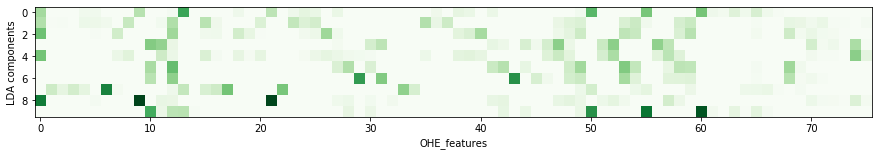

In [49]:
fig, ax = plt.subplots(figsize=(15,4))
ax.imshow(lda_components_norm, cmap='Greens')
ax.set_xlabel('OHE_features')
ax.set_ylabel('LDA components')
display(fig)
plt.close(fig)

Thus, it can be cosidered as a cluster of people with specific demographic characteristics.

For example, lda_0 is people over 60 (ALTERSKATEGORIE_GROB_4). lda_1 is people from 46 to 60 (ALTERSKATEGORIE_GROB_3) with consumption type 'Universal' (D19_KONSUMTYP_1).

Further interpretations is impossible due to missing documentation on other features

In [50]:
print('Top-5 features contributing to lda components')
for i_lda in range(10):
    display(HTML(lda_components_norm.loc[i_lda,:].sort_values(ascending=False).head().to_frame(
                             name='lda_'+str(i_lda)).to_html()))

Top-5 features contributing to lda components


,lda_0
ALTERSKATEGORIE_GROB_4,0.140392
CJT_TYP_6_5,0.122994
CJT_TYP_3_5,0.107193
CJT_TYP_5_5,0.105974
D19_SOZIALES_0,0.078949


,lda_1
ALTERSKATEGORIE_GROB_3,0.070815
D19_SOZIALES_0,0.069446
VK_DISTANZ_3,0.068434
D19_KONSUMTYP_1,0.064362
VK_ZG11_2,0.057375


,lda_2
D19_SOZIALES_0,0.112055
VK_ZG11_5,0.082643
ALTERSKATEGORIE_GROB_3,0.081754
VK_DISTANZ_8,0.076778
CJT_TYP_3_4,0.064761


,lda_3
D19_KONSUMTYP_MAX_9,0.098544
CJT_TYP_6_2,0.094192
CJT_TYP_5_2,0.093855
CJT_TYP_3_1,0.091386
ALTERSKATEGORIE_GROB_2,0.089293


,lda_4
D19_SOZIALES_0,0.108583
PRAEGENDE_JUGENDJAHRE_14,0.094625
CJT_TYP_5_2,0.074399
CJT_TYP_3_2,0.062421
CJT_TYP_6_2,0.051191


,lda_5
ALTERSKATEGORIE_GROB_3,0.115606
CJT_TYP_5_3,0.100295
PRAEGENDE_JUGENDJAHRE_8,0.081815
CJT_TYP_6_4,0.079853
D19_KONSUMTYP_MAX_9,0.075319


,lda_6
VK_DISTANZ_11,0.158379
VK_ZG11_8,0.148869
VK_ZG11_10,0.099479
ALTERSKATEGORIE_GROB_3,0.092192
CJT_TYP_5_3,0.077838


,lda_7
D19_KONSUMTYP_MAX_2,0.170352
D19_KONSUMTYP_3,0.108193
VK_ZG11_1,0.105799
VK_DISTANZ_1,0.091066
ALTERSKATEGORIE_GROB_4,0.056075


,lda_8
D19_KONSUMTYP_MAX_8,0.217334
D19_KONSUMTYP_9,0.215490
D19_SOZIALES_0,0.175938
CJT_TYP_3_2,0.043914
PRAEGENDE_JUGENDJAHRE_14,0.035550


,lda_9
CJT_TYP_3_5,0.206232
CJT_TYP_5_5,0.181873
CJT_TYP_6_5,0.157413
D19_KONSUMTYP_MAX_9,0.134490
ALTERSKATEGORIE_GROB_4,0.064397


## LDA interpreted as soft clustering

In [51]:
print('General population (azdias)')
azdias_dimred = pd.DataFrame(lda.transform(azdias_csr), index=azdias_ohe.index,
                             columns = ['lda_'+str(i) for i in range(10)])
azdias_dimred.head()

General population (azdias)


,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9
LNR,,,,,,,,,,
910215,0.016669,0.016667,0.016667,0.016810,0.016670,0.016667,0.016667,0.016667,0.016668,0.849848
910220,0.012500,0.012500,0.012500,0.684997,0.012503,0.012501,0.214998,0.012500,0.012501,0.012501
910225,0.009092,0.009093,0.009093,0.316029,0.009110,0.009094,0.009092,0.009091,0.611214,0.009092
910226,0.231725,0.009093,0.009093,0.009091,0.009092,0.298512,0.009093,0.009092,0.406116,0.009094
910241,0.010001,0.909984,0.010003,0.010000,0.010002,0.010005,0.010003,0.010000,0.010002,0.010000


In [52]:
print('Customers')
customers_dimred = pd.DataFrame(lda.transform(customers_csr), index=customers_ohe.index,
                             columns = ['lda_'+str(i) for i in range(10)])
customers_dimred.head()

Customers


,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9
LNR,,,,,,,,,,
9626,0.166356,0.179424,0.009091,0.009091,0.009091,0.009091,0.009091,0.446605,0.009091,0.153069
9628,0.331429,0.014288,0.554247,0.014286,0.014317,0.014286,0.014286,0.014287,0.014287,0.014287
143872,0.009094,0.009091,0.009091,0.009092,0.009091,0.009091,0.099999,0.477322,0.100000,0.268130
143873,0.606179,0.009094,0.009091,0.009091,0.009091,0.009091,0.009091,0.321083,0.009091,0.009100
143874,0.009091,0.858791,0.009093,0.009091,0.009092,0.009104,0.009093,0.068461,0.009091,0.009091


Below I show the LDA components (y-axis) for 60 randomly selected people (blue palette) from general population (x-axis). The second picture is for 60 randomly selected customers (orange palette)

With each person having several nonzero components, LDA can be considered as soft clustering. The components are probabilities of belonging to each cluster. 

In most cases each person has one dominating component, which allows to convert soft clustering to hard clustering.

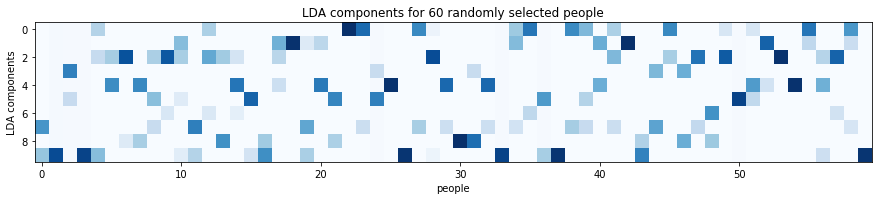

In [53]:
fig, ax = plt.subplots(figsize=(15,4))
ax.imshow(azdias_dimred.sample(60).T.values, cmap='Blues')
ax.set_title('LDA components for 60 randomly selected people')
ax.set_xlabel('people')
ax.set_ylabel('LDA components')
display(fig)
plt.close(fig)

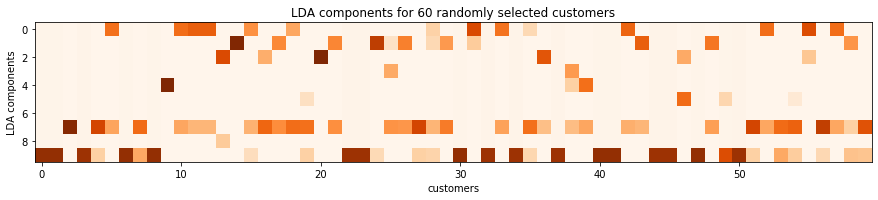

In [54]:
fig, ax = plt.subplots(figsize=(15,4))
ax.imshow(customers_dimred.sample(60).T.values, cmap='Oranges')
ax.set_title('LDA components for 60 randomly selected customers')
ax.set_xlabel('customers')
ax.set_ylabel('LDA components')
display(fig)
plt.close(fig)

Already with these two pictures, one can easily see that most of customers (unlike the general population) belong the 'lda_7' cluster. Customers are also overrepresented in cluster 'lda_9'

This clusters are characterized by the top-5 features shown below. Unfortunately, these features are not described in Excel documentation files

In [55]:
for i_lda in [7,9]:
    display(HTML(lda_components_norm.loc[i_lda,:].sort_values(ascending=False).head().to_frame(
                             name='lda_'+str(i_lda)).to_html()))

,lda_7
D19_KONSUMTYP_MAX_2,0.170352
D19_KONSUMTYP_3,0.108193
VK_ZG11_1,0.105799
VK_DISTANZ_1,0.091066
ALTERSKATEGORIE_GROB_4,0.056075


,lda_9
CJT_TYP_3_5,0.206232
CJT_TYP_5_5,0.181873
CJT_TYP_6_5,0.157413
D19_KONSUMTYP_MAX_9,0.134490
ALTERSKATEGORIE_GROB_4,0.064397


In [56]:
azdias_dimred.to_csv('arvato_data/azdias_lda.csv')
customers_dimred.to_csv('arvato_data/customers_lda.csv')

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

##### Read cleaned data

In [94]:
#del mailout
#del test

In [57]:
if 'mailout' not in dir():
    mailout = pd.read_pickle('arvato_data/mailout_cleaned.pkl')
print('mailout', mailout.shape)

mailout (42962, 365)


In [58]:
responded = mailout.pop('RESPONSE')

In [59]:
if 'test' not in dir():
    test = pd.read_pickle('arvato_data/test_cleaned.pkl')
print('test',test.shape)

test (42833, 364)


In [60]:
#for colu in object_columns:
#    print(colu)
#    mailout[colu] = les[colu].transform(mailout[colu].astype(str))
#    test[colu] = les[colu].transform(test[colu].astype(str))    

##### Encode object (string)

In [61]:
object_columns = mailout.select_dtypes(include='object').columns.tolist()
les2 = dict()
tmp = pd.concat([mailout.astype(str), 
                 test.astype(str)], axis=0)
for colu in object_columns:
    print(colu)
    les2[colu] = LabelEncoder().fit(tmp[colu])
    mailout[colu] = les2[colu].transform(mailout[colu].astype(str))
    test[colu] = les2[colu].transform(test[colu].astype(str))    

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
OST_WEST_KZ


## Benchmark - Random Forest

In [64]:
cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=7690)
rf = RandomForestClassifier(n_estimators=1200, class_weight='balanced')
gs = GridSearchCV(estimator=rf,
                  param_grid={'max_depth': [i for i in range(6,15)],
                              'min_samples_leaf': [2**i for i in range(7,12)]},
                  return_train_score=True, refit=True,
                  cv=cv, scoring='roc_auc', n_jobs=4, verbose=1)

In [65]:
responded = responded.sample(frac=1.0)
mailout = mailout.loc[responded.index,:]

In [66]:
%%time
gs.fit(mailout, responded)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 42.4min
[Parallel(n_jobs=4)]: Done 225 out of 225 | elapsed: 48.9min finished


CPU times: user 53.6 s, sys: 333 ms, total: 53.9 s
Wall time: 49min 43s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7690, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1200, n_jobs=None,
                                              oob_score=False,
                                  

In [67]:
cv_results = pd.DataFrame(gs.cv_results_)
#cc = cv_results.columns; cc
cv_results.set_index('rank_test_score', inplace=True)
cv_results.sort_index(inplace=True)
columns_to_show = ['mean_test_score', 'std_test_score'] + [c for c in cv_results.columns 
                   if (c.startswith('param_'))] + ['mean_train_score', 'std_train_score'] 
display(cv_results[columns_to_show].head(9))

,mean_test_score,std_test_score,param_max_depth,param_min_samples_leaf,mean_train_score,std_train_score
rank_test_score,,,,,,
1,0.737501,0.025133,7,1024,0.822080,0.002497
2,0.735926,0.022606,14,1024,0.822682,0.002454
3,0.735743,0.026772,12,1024,0.822078,0.001959
4,0.735355,0.024718,8,1024,0.822197,0.003580
5,0.734936,0.024760,11,1024,0.822837,0.002716
6,0.734715,0.025107,9,1024,0.821603,0.003031
7,0.734126,0.024674,6,1024,0.819395,0.003208
8,0.734028,0.025303,10,1024,0.822456,0.002341
9,0.733615,0.025445,13,1024,0.822675,0.002106


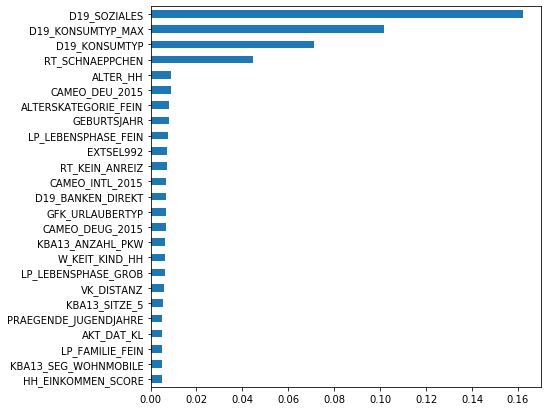

In [68]:
feature_importances = pd.Series(gs.best_estimator_.feature_importances_, index=mailout.columns).sort_values(ascending=False)
#display(feature_importances.head(25))
feature_importances.head(25)[::-1].plot.barh(figsize=(7,7));

## Feed-forward neural network with  embeddings for categorical columns

In [217]:
mailout = pd.read_pickle('arvato_data/mailout_cleaned.pkl')
responded = mailout.pop('RESPONSE')
print('mailout', mailout.shape)
test = pd.read_pickle('arvato_data/test_cleaned.pkl')
print('test',test.shape)
#
object_columns = mailout.select_dtypes(include='object').columns.tolist()
#print(object_columns)
for colu in object_columns:
    mailout[colu] = mailout[colu].astype(str)
    test[colu] = test[colu].astype(str)

mailout (42962, 364)
test (42833, 364)


In [218]:
top_categorical_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX',  'D19_KONSUMTYP', 
                           'RT_SCHNAEPPCHEN'] # , 'CAMEO_DEU_2015'
#top_ordinal_columns = ['ALTER_HH']
top_ordinal_columns = []

I  build a simple feed-forward deep learning model and use 2-dimensional embedding for each column. 

In [219]:
#from sklearn.preprocessing import MinMaxScaler
#scalers=dict()
#for colu in top_numerical_columns:
#    scalers[colu] = MinMaxScaler()

I will use 1-dimensional embedding for ordinal columns.
For categorical columns the embedding dimension can be specified per hand for each column.
With 5-30 categories, a 2-dimensional embedding is reasonable.

In [220]:
# value of the dictionary is a tuple (number of unique values, desired_output_dimension)
categorical_dict = {colu:((pd.concat([mailout[colu], test[colu]], axis=0)).nunique(), 2) 
                    for colu in top_categorical_columns}
print(categorical_dict)
ord_dict = {colu:((pd.concat([mailout[colu], test[colu]], axis=0)).nunique(), 1) for colu in top_ordinal_columns}
print(ord_dict)
cat_ord_dict = categorical_dict.copy()
cat_ord_dict.update(ord_dict)

{'D19_SOZIALES': (7, 2), 'D19_KONSUMTYP_MAX': (6, 2), 'D19_KONSUMTYP': (8, 2), 'RT_SCHNAEPPCHEN': (6, 2)}
{}


In [221]:
#mailout['D19_KONSUMTYP_MAX'].value_counts()

In [222]:
def create_model(cat_ord_dict, hidden=(16,), activation='relu'):
    
    assert len(hidden)>0 # at least 1 hidden layers
    
    # ----- embeddings
    input_cat_ord = dict()
    embedding_cat_ord = dict()
    for k, v in cat_ord_dict.items():
        input_cat_ord[k] = layers.Input(shape=(1,), name='input_'+k)
        embedding_cat_ord[k] = layers.Embedding(input_dim=v[0], output_dim=v[1],
                                                name='emb_'+k)(input_cat_ord[k])
        embedding_cat_ord[k] = layers.Flatten(name='emb_flatten_'+k)(embedding_cat_ord[k])
        
    x = layers.Concatenate(name='emb_concatenate')(list(embedding_cat_ord.values()))
    
    # ----- hidden layers
    for i, n in enumerate(hidden[:-1]):
        x = layers.Dense(hidden[i], activation=activation, name='dense_'+str(i))(x)
        #x = layers.BatchNormalization(name='bn_'+str(i))(x)
    # ----- last layer without BN
    x = layers.Dense(hidden[-1], activation=activation, name='dense_last')(x)

    # ----- final layer
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = models.Model(inputs=list(input_cat_ord.values()), outputs=output)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['AUC'])

    return model

## Prepare input

Embedding layer requires input with consequtive integers. Since this is not guaranteed in the original data,  I encode all columns

In [223]:
def prepare_input(cat_ord_dict, mailout, test):
    from sklearn.preprocessing import LabelEncoder
    
    encoders = dict()
    input_mailout = list()
    input_test = list()
    
    for colu in cat_ord_dict.keys():
        encoders[colu] = LabelEncoder() # necessary because embedding expects consequitive integers and not -1
        encoders[colu].fit(pd.concat([mailout[colu], test[colu]], axis=0))
        input_mailout.append(encoders[colu].transform(mailout[colu]))
        input_test.append(encoders[colu].transform(test[colu]))
        
    return encoders, input_mailout, input_test

In [224]:
# ----- prepare input
encoders, input_mailout, input_test = prepare_input(cat_ord_dict, mailout, test)

## Fit model

In [259]:
hidden=(8,)
activation='relu'
model2h = create_model(cat_ord_dict, hidden=hidden, activation=activation)
model2h.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_D19_SOZIALES (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_D19_KONSUMTYP_MAX (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_D19_KONSUMTYP (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_RT_SCHNAEPPCHEN (InputLay [(None, 1)]          0                                            
____________________________________________________________________________________________

In [260]:
filename = 'HIDDEN-{:s}_ACT{:s}_{:%m%d_%H%M}'.format('-'.join(str(i) for i in hidden), 
                                                         activation,
                                                         datetime.today())
log_dir = 'logs/'+filename
model_dir = 'models/'+filename
print(filename)
tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=10, write_graph=False, write_images=True)
early_cb = callbacks.EarlyStopping(patience=3)
lr_cb = callbacks.ReduceLROnPlateau(factor=0.5, patience=1)
mo_cb = callbacks.ModelCheckpoint(model_dir, save_best_only=True)

HIDDEN-8_ACTrelu_0412_2119


In [261]:
hist = model2h.fit(x=input_mailout, y=responded.values, class_weight={0:0.01, 1:0.99},
                   epochs=10, verbose=1, batch_size=2**7,
                   callbacks=[tb_cb, early_cb, lr_cb, mo_cb],
                   validation_split=0.3, shuffle=True) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30073 samples, validate on 12889 samples
Epoch 1/10
30073/30073 [==============================] - 2s 69us/sample - loss: 0.0152 - AUC: 0.7434 - val_loss: 0.0136 - val_AUC: 0.7541
Epoch 2/10
30073/30073 [==============================] - 1s 48us/sample - loss: 0.0138 - AUC: 0.7639 - val_loss: 0.0125 - val_AUC: 0.7562
Epoch 3/10
30073/30073 [==============================] - 1s 43us/sample - loss: 0.0128 - AUC: 0.7646 - val_loss: 0.0122 - val_AUC: 0.7551
Epoch 4/10
30073/30073 [==============================] - 1s 24us/sample - loss: 0.0125 - AUC: 0.7724 - val_loss: 0.0122 - val_AUC: 0.7528
Epoch 5/10
30073/30073 [==============================] - 1s 25us/sample - loss: 0.0124 - AUC: 0.7723 - val_loss: 0.0122 - val_AUC: 0.7510
Epoch 6/10
30073/30073 [==============================] - 1s 24us/sample - loss: 0.0124 - AUC: 0.7740 - val_loss: 0.0122 - val_AUC: 0.7509


## Cross-validation for comparison with benchmark

In [263]:
valid_AUCs = list()
cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=7690)
for train_ind, val_ind in cv.split(mailout, responded):
    encoders, input_train, input_val = prepare_input(cat_ord_dict, mailout.iloc[train_ind,:], 
                                                                   mailout.iloc[val_ind,:])
    respond_train, respond_val = responded.values[train_ind], responded.values[val_ind]
    
    K.clear_session()
    model2h = create_model(cat_ord_dict, hidden=hidden, activation=activation)
    hist = model2h.fit(x=input_train, y=respond_train, class_weight={0:0.01, 1:0.99},
                       epochs=3, verbose=0, batch_size=2**7,
                       validation_data=(input_val, respond_val), shuffle=True)
    valid_AUCs.append(hist.history['val_AUC'][-1])
print(valid_AUCs)

print('mean AUC', np.mean(valid_AUCs))
print('std AUC', np.std(valid_AUCs))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
[0.74373895, 0.77306825, 0.8078089, 0.7543568, 0.7641087]
mean AUC 0.7686163
std AUC 0.021901652


# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

## Retrain on all data and predict test

In [264]:
K.clear_session()
model2h = create_model(cat_ord_dict, hidden=hidden, activation=activation)
encoders, input_mailout, input_test = prepare_input(cat_ord_dict, mailout, test)
hist_all_data = model2h.fit(x=input_mailout, y=responded.values, class_weight={0:0.01, 1:0.99},
                   epochs=3, verbose=0, batch_size=2**7,
                   shuffle=True) 

  ...
    to  
  ['...']


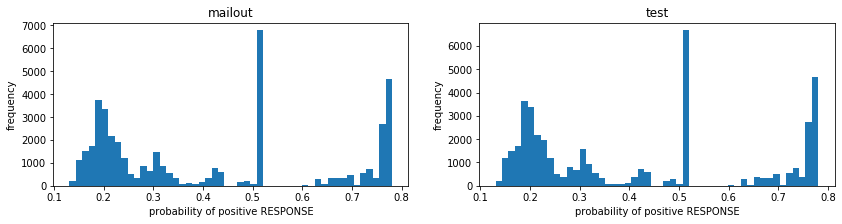

In [265]:
mailout_prediction = model2h.predict(x=input_mailout)
test_prediction = model2h.predict(x=input_test)

#mailout_prediction[:5]

fig, ax = plt.subplots(1,2, figsize=(14,3))
ax[0].hist(mailout_prediction.flatten(), bins=50)
ax[0].set_title('mailout')
ax[0].set_ylabel('frequency')
ax[0].set_xlabel('probability of positive RESPONSE')
#
ax[1].hist(test_prediction.flatten(), bins=50)
ax[1].set_title('test')
ax[1].set_ylabel('frequency')
ax[1].set_xlabel('probability of positive RESPONSE')
display(fig)
plt.close(fig)